In [19]:
#imports
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm


import matplotlib.pyplot as plt
from PIL import Image

import math


# Loading Dataset

In [20]:
mask_path='/kaggle/input/kittiroadsegmentation/training/gt_image_2'
img_path='/kaggle/input/kittiroadsegmentation/training/image_2'

test_path='/kaggle/input/kittiroadsegmentation/testing' #videos

In [21]:
# Number of training examples
train_set_size = int(len(os.listdir(img_path)) * 0.8)
print(f"Number of Training Examples: {train_set_size}")

validation_set_size = int(len(os.listdir(img_path)) * 0.1)
print(f"Number of Validation Examples: {validation_set_size}")

test_set_size = int(len(os.listdir(img_path)) - train_set_size - validation_set_size)
print(f"Number of Testing Examples: {test_set_size}")

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [22]:
def loadImages(path,mask=False):
    result = [] 
    images = os.listdir(path)
    if mask==True:
        images = [entry for entry in images if "road" in entry]

    for image in images:
        im = Image.open(os.path.join(path, image))
        resized_im = im.resize((128, 128))
        res = np.asarray(resized_im)
        result.append(res)
    return np.array(result)

In [23]:
%matplotlib inline
def show_images(images, num_images_to_show):
    fig = plt.figure()
    for i in range(1,num_images_to_show+1):
        fig.add_subplot(1,num_images_to_show,i)
        img = images[i-1,:]
        plt.imshow(img)


In [24]:
data=loadImages(img_path,mask=False)

In [25]:
data.shape

(289, 128, 128, 3)

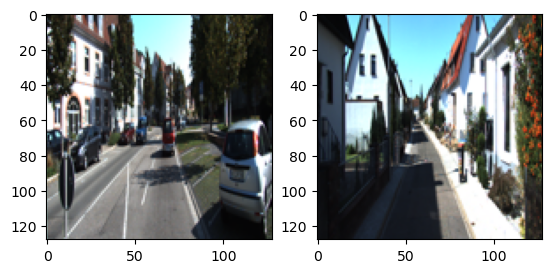

In [26]:
show_images(data,2)

In [27]:
true_mask=loadImages(mask_path,mask=True)

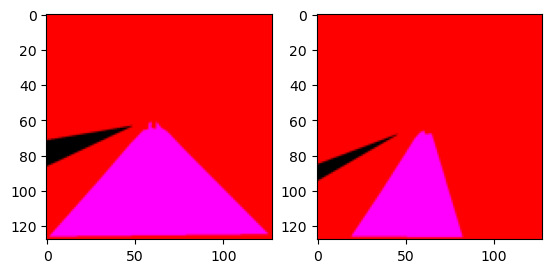

In [28]:
show_images(true_mask,2)

In [29]:
def convert_to_binary_mask(true_mask):
    noMasks=len(true_mask)
    for i in range(noMasks):
        #convert all masks to just binary masks (road and no road)
        road_label =np.array([255, 0, 255])
        cond=np.all(true_mask[i] == road_label, axis = 2)
        true_mask[i]=true_mask[i] * cond[..., np.newaxis]

In [30]:
convert_to_binary_mask(true_mask)

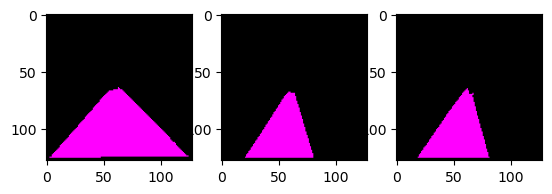

In [31]:
show_images(true_mask,3)

In [32]:
true_mask=np.dot(true_mask[..., :3], [0.2989, 0.5870, 0.1140])
true_mask=np.expand_dims(true_mask, axis=-1)

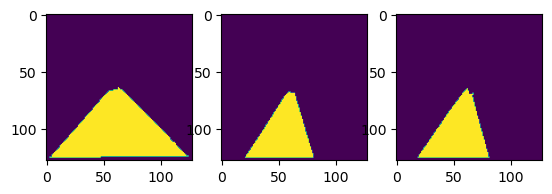

In [33]:
show_images(true_mask,3)

In [34]:
true_mask[true_mask != 0.0]=1.0

In [35]:
data  = data / 255.0

In [36]:
#train_test_validation split
X_train=data[:train_set_size].transpose((0, 3, 1, 2))
y_train=true_mask[:train_set_size].transpose((0, 3, 1, 2))
print(f'training set size {X_train.shape}')

X_val=data[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))
y_val=true_mask[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))
print(f'val set size {X_val.shape}')

X_test=data[train_set_size+validation_set_size:train_set_size+validation_set_size+test_set_size].transpose((0, 3, 1, 2))
y_test=true_mask[train_set_size+validation_set_size:train_set_size+validation_set_size+test_set_size].transpose((0, 3, 1, 2))
print(f'test set size {X_val.shape}')


training set size (231, 3, 128, 128)
val set size (28, 3, 128, 128)
test set size (28, 3, 128, 128)


In [37]:
#create dataset class
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, imgs,mask):
        self.imgs=imgs
        self.mask=mask

    def __len__(self):
        return len(self.imgs)

    def get_batch_imgs(self, idx):
        # Fetch a batch of inputs
        return self.imgs[idx]
    
    def get_batch_masks(self, idx):
    # Fetch a batch of inputs
        return self.mask[idx]

    
    def __getitem__(self, index):
        imgs=self.get_batch_imgs(index)
        masks=self.get_batch_masks(index)
        return imgs,masks

In [38]:
train_dataset = ImageDataset(X_train,y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(X_test, y_test)

# Create a DataLoader from the dataset
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_dataloader=DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader=DataLoader(val_dataset, batch_size=16, shuffle=False)

# Model U-NET

# U-NET architecture (from scratch)
# ![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [55]:
#since there is alot of double Conv in this architecture it's better to create a class to write less redundant code
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv,self).__init__() # essentail to use nn.Module
        #ex : for the first layer
        #in_channels would be 3 for RGB image 
        #out_channels would be 64
        #bias is set to false because we apply batch norm later so it's unnecassary
        self.dconv=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.dconv(x)

    
    
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET,self).__init__()
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) #this is not deconv this just upsampling
            self.ups.append(DoubleConv(feature*2, feature))

            

        self.left_over = DoubleConv(features[-1], features[-1]*2) #this represents the last part which starts the UP phase
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) #output segmentation  map

    def forward(self,x):
        skip_connections = []
        
        #starting the down phase will iterate through the downs module
        for layer in self.downs:
            x=layer(x)
            skip_connections.append(x)#save this to feed it later
            x=self.pool(x)
        
        #to move from left to right we pass through the "left_over"
        
        x=self.left_over(x)
        skip_connections=skip_connections[::-1]
        for idx in range(0,len(self.ups), 2): #our goal it so feed to transposed conv and add skipped connection ups has 2 steps in each so we will make it a step of 2
            
            sc=skip_connections[idx//2]
            x=self.ups[idx](x) #step 1
            
            if x.shape != sc.shape:
                x = TF.resize(x, size=sc.shape[2:])

            concat_skip = torch.cat((sc, x), dim=1) #concatination step
            x = self.ups[idx+1](concat_skip) #step 2


        return torch.sigmoid(self.final_conv(x))#last step in forward            
        

In [56]:
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()
        self.eps = 1e-6

    def forward(self, y_pred, y_true):
        # Flatten the input tensors
        y_pred = y_pred.view(-1)        
        y_true = y_true.view(-1)
        # Calculate the confusion matrix
        intersection = (y_pred * y_true).sum()
        union = y_pred.sum() + y_true.sum() - intersection

        # Calculate the IoU and return the complement as the loss
        iou = intersection / (union + self.eps)
        return 1 - iou


In [57]:
import torch.optim as optim

EPOCHS=150
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# loss_fn = IoULoss().to(DEVICE)
loss_fn =nn.BCELOSS().to(DEVICE)
LEARNING_RATE=1e-3

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [58]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()

    losses = []

    for train_input, train_mask in tqdm(data_loader):
        train_mask = train_mask.to(device)
        train_input=train_input.to(device)
        
        outputs=model(train_input.float())
        
        
        loss = loss_fn(outputs.float(), train_mask.float())
        
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return np.mean(losses)

In [59]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []

    with torch.no_grad():
        for val_input, val_mask in data_loader:
            
            val_mask = val_mask.to(device)
            val_input=val_input.to(device)
            outputs=model(val_input.float())
           
            loss = loss_fn(outputs.float(), val_mask.float())
            losses.append(loss.item())

    return np.mean(losses)

In [60]:
from collections import defaultdict
history = defaultdict(list)

In [61]:
loss=math.inf
for epoch in range(EPOCHS):


    train_loss = train_epoch(model,train_dataloader,loss_fn, optimizer, DEVICE)

    
    val_loss = eval_model(model,val_dataloader,loss_fn, DEVICE)
    
    
    if epoch%5 == 0 :
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        print(f'Train loss {train_loss}')
        print(f'Val   loss {val_loss}')
        print()
        
    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


Epoch 1/150
----------
Train loss 0.7254737337430318
Val   loss 0.8026439249515533



100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


Epoch 6/150
----------
Train loss 0.4490198771158854
Val   loss 0.5060389339923859



100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


Epoch 11/150
----------
Train loss 0.3691048781077067
Val   loss 0.43221724033355713



100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


Epoch 16/150
----------
Train loss 0.3456121246019999
Val   loss 0.38890084624290466



100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


Epoch 21/150
----------
Train loss 0.33063081502914426
Val   loss 0.38738420605659485



100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


Epoch 26/150
----------
Train loss 0.30171151558558146
Val   loss 0.3813476860523224



100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


Epoch 31/150
----------
Train loss 0.3003777543703715
Val   loss 0.39571303129196167



100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


Epoch 36/150
----------
Train loss 0.27550676266352336
Val   loss 0.4172033667564392



100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


Epoch 41/150
----------
Train loss 0.2379338582356771
Val   loss 0.4037334620952606



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 46/150
----------
Train loss 0.20228628714879354
Val   loss 0.4019932448863983



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 51/150
----------
Train loss 0.1943546414375305
Val   loss 0.4142690896987915



100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


Epoch 56/150
----------
Train loss 0.1793884038925171
Val   loss 0.4104708433151245



100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


Epoch 61/150
----------
Train loss 0.1482414444287618
Val   loss 0.4396137297153473



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 66/150
----------
Train loss 0.1411872148513794
Val   loss 0.40761831402778625



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 71/150
----------
Train loss 0.13034319877624512
Val   loss 0.42254844307899475



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 76/150
----------
Train loss 0.10803542931874593
Val   loss 0.4097220301628113



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 81/150
----------
Train loss 0.10020423730214437
Val   loss 0.42410528659820557



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 86/150
----------
Train loss 0.08995809157689412
Val   loss 0.4296506941318512



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 91/150
----------
Train loss 0.07886584202448527
Val   loss 0.41897833347320557



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 96/150
----------
Train loss 0.07795792023340861
Val   loss 0.43232786655426025



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 101/150
----------
Train loss 0.06240932941436768
Val   loss 0.4139731526374817



100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


Epoch 106/150
----------
Train loss 0.06977297067642212
Val   loss 0.42074817419052124



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 111/150
----------
Train loss 0.055573566754659014
Val   loss 0.42905282974243164



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 116/150
----------
Train loss 0.05344175497690837
Val   loss 0.41901734471321106



100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


Epoch 121/150
----------
Train loss 0.05632270971934001
Val   loss 0.4195970296859741



100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


Epoch 126/150
----------
Train loss 0.05909340778986613
Val   loss 0.41697219014167786



100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


Epoch 131/150
----------
Train loss 0.0512138843536377
Val   loss 0.43259090185165405



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 136/150
----------
Train loss 0.04774347941080729
Val   loss 0.4274682402610779



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 141/150
----------
Train loss 0.04802923202514649
Val   loss 0.40487831830978394



100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 146/150
----------
Train loss 0.047935243447621664
Val   loss 0.4262174963951111



100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


In [75]:
model.load_state_dict(torch.load('/kaggle/working/best_model_state.bin'))

<All keys matched successfully>

In [76]:
for x,y in train_dataloader:
    test=model(x.float().to(DEVICE))
    break

In [77]:
test.shape

torch.Size([16, 1, 128, 128])

In [78]:
wow=test.cpu().detach().numpy()

In [79]:
wow.shape

(16, 1, 128, 128)

In [80]:
wow=wow.transpose(0,2,3,1)

In [81]:
wow.shape

(16, 128, 128, 1)

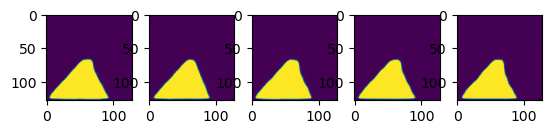

In [82]:
show_images(wow,5)

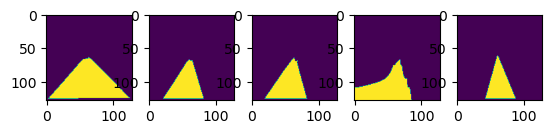

In [83]:
show_images(y_train.transpose(0,2,3,1),5)

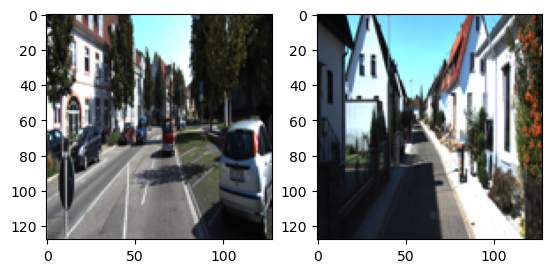

In [84]:
show_images(X_train.transpose(0,2,3,1),2)

In [85]:
for x,y in test_dataloader:
    t_test=model(x.float().to(DEVICE))
    break

In [86]:
wow_test=t_test.cpu().detach().numpy()
wow_test=wow_test.transpose(0,2,3,1)

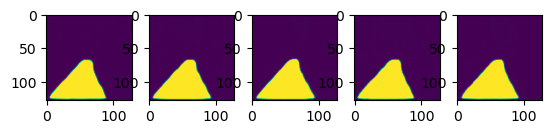

In [87]:
show_images(wow_test,5)

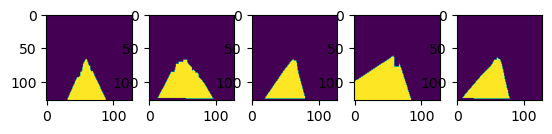

In [88]:
show_images(y_test.transpose(0,2,3,1),5)
